In [1]:
import tensorflow as tf
import requests
%pylab inline
import numpy as np


C:\Users\T480\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
# from https://github.com/m-colombo/Tensorflow-EchoStateNetwork/blob/master/esn_cell.py

from tensorflow.python.ops import rnn_cell_impl
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.framework.ops import convert_to_tensor


class ESNCell(rnn_cell_impl.RNNCell):
    """Echo State Network Cell.

    Based on http://www.faculty.jacobs-university.de/hjaeger/pubs/EchoStatesTechRep.pdf
    Only the reservoir, the randomized recurrent layer, is modelled. The readout trainable layer
    which map reservoir output to the target output is not implemented by this cell,
    thus neither are feedback from readout to the reservoir (a quite common technique).

    Here a practical guide to use Echo State Networks:
    http://minds.jacobs-university.de/sites/default/files/uploads/papers/PracticalESN.pdf

    Since at the moment TF doesn't provide a way to compute spectral radius
    of a matrix the echo state property necessary condition `max(eig(W)) < 1` is approximated
    scaling the norm 2 of the reservoir matrix which is an upper bound of the spectral radius.
    See https://en.wikipedia.org/wiki/Matrix_norm, the section on induced norms."""
    
    def __init__(self, num_units, wr2_scale=0.7, connectivity=0.1, leaky=1.0, activation=math_ops.tanh,
               win_init=init_ops.random_normal_initializer(),
               wr_init=init_ops.random_normal_initializer(),
               bias_init=init_ops.random_normal_initializer()):
        """Initialize the Echo State Network Cell.

        Args:
          num_units: Int or 0-D Int Tensor, the number of units in the reservoir
          wr2_scale: desired norm2 of reservoir weight matrix.
            `wr2_scale < 1` is a sufficient condition for echo state property.
          connectivity: connection probability between two reservoir units
          leaky: leaky parameter
          activation: activation function
          win_init: initializer for input weights
          wr_init: used to initialize reservoir weights before applying connectivity mask and scaling
          bias_init: initializer for biases
        """
        self._num_units = num_units
        self._leaky = leaky
        self._activation = activation
        
        def _wr_initializer(shape, dtype, partition_info=None):
            wr = wr_init(shape, dtype=dtype)

            connectivity_mask = math_ops.cast(
                  math_ops.less_equal(
                    random_ops.random_uniform(shape),
                    connectivity),
                dtype)

            wr = math_ops.multiply(wr, connectivity_mask)

            wr_norm2 = math_ops.sqrt(math_ops.reduce_sum(math_ops.square(wr)))

            is_norm_0 = math_ops.cast(math_ops.equal(wr_norm2, 0), dtype)

            wr = wr * wr2_scale / (wr_norm2 + 1 * is_norm_0)

            return wr
    
        self._win_initializer = win_init
        self._bias_initializer = bias_init
        self._wr_initializer = _wr_initializer
        
    

    

    @property
    def output_size(self):
        return self._num_units

    @property
    def state_size(self):
        return self._num_units

    def __call__(self, inputs, state, scope=None):
        
        """ Run one step of ESN Cell

            Args:
              inputs: `2-D Tensor` with shape `[batch_size x input_size]`.
              state: `2-D Tensor` with shape `[batch_size x self.state_size]`.
              scope: VariableScope for the created subgraph; defaults to class `ESNCell`.

            Returns:
              A tuple `(output, new_state)`, computed as
              `output = new_state = (1 - leaky) * state + leaky * activation(Win * input + Wr * state + B)`.

            Raises:
              ValueError: if `inputs` or `state` tensor size mismatch the previously provided dimension.
        """

        inputs = convert_to_tensor(inputs)
        input_size = inputs.get_shape().as_list()[1]
        dtype = inputs.dtype

        with vs.variable_scope(scope or type(self).__name__, reuse = tf.AUTO_REUSE):  # "ESNCell"
            
            win = vs.get_variable("InputMatrix", [input_size, self._num_units], dtype=dtype,
                            trainable=False, initializer=self._win_initializer)
            wr = vs.get_variable("ReservoirMatrix", [self._num_units, self._num_units], dtype=dtype,
                           trainable=False, initializer=self._wr_initializer)
            b = vs.get_variable("Bias", [self._num_units], dtype=dtype, trainable=False, initializer=self._bias_initializer)

            in_mat = array_ops.concat([inputs, state], axis=1)
            weights_mat = array_ops.concat([win, wr], axis=0)

            output = (1 - self._leaky) * state + self._leaky * self._activation(math_ops.matmul(in_mat, weights_mat) + b)

        return output, output


In [3]:
def get_data(filename):
    #get the data
    with open (filename) as f:
        txt_data = [x.split(';') for x in f.readlines()]
        tt = [x[3].strip() for x in txt_data[1:]]
        rf = [x[4].strip() for x in txt_data[1:]]
        raw_data = np.array((tt,rf),dtype=float).T
        #scale the data to 0:1
        data_max = np.amax(raw_data,axis=0)
        scaled_data = raw_data / data_max
        #whiten the data
        data_mean = np.mean(scaled_data,axis = 0)
        data_std = np.std(scaled_data, axis = 0)
        white_data = (scaled_data - data_mean ) / data_std
        return [white_data, scaled_data, raw_data], [data_max, data_mean, data_std]

In [4]:
def break_sequence(data,lookback = 25):
    #data assumed to be shape (variables,timesteps)
    n = data.shape[1]
    windows = [data[:,i - lookback : i] for i in np.arange(lookback,n)]
    sequence = np.stack(windows,axis = 1)
    return sequence

In [5]:
def reservoir_computing(train, test,state_size, con, wr2, l):
    tf.reset_default_graph()
    esn =  ESNCell(state_size,connectivity = con, wr2_scale = wr2, leaky = l)
    #train it
    with tf.Session() as training:
        outputs, states = tf.nn.dynamic_rnn(esn,train.T,dtype = tf.float64)
        #run
        training.run(tf.global_variables_initializer())
        val = outputs.eval(session=training)
        #train the readout
        beta = 0.1
        t = train[:,:,1:].reshape(1,n-1)
        u = train[:,:,:-1].reshape(n-1,1)
        x = val[:-1,:,:].reshape(n-1,state_size)
        b = np.ones((n-1,1))
        design_mat = np.append(np.append(b,u,axis=1),x,axis=1)
        w_out = t @( design_mat.T @ np.linalg.inv(design_mat @ design_mat.T - beta * np.eye(n-1))).T
    with tf.Session() as testing:
        out_t, states_t = tf.nn.dynamic_rnn(esn, test.T,dtype = tf.float64)
        testing.run(tf.global_variables_initializer())
        val_t = out_t.eval(session = testing)
        x_test = val_t[:-1,:,:].reshape(m-1,state_size)
        t_test = test[:,:,1:].reshape(1,m-1)
        u_test = test[:,:,:-1].reshape(m-1,1)
        b_test = np.ones((m-1,1))
        design_test = np.append(np.append(b_test,u_test,axis=1),x_test,axis=1)
        y = w_out @ design_test.T
    return w_out, y

In [6]:
variable = []
#get the (pre-processed) data
filename = 'temperature_toy.txt'
#get the data
preproc = True
data_list, stat_list = get_data(filename)

if preproc:
    data = data_list[0].T
else:
    data = data_list[2].T
    
#data = data_list[1].T
#n is the length of the training sequence
#m is the length of the test sequence

m = 300
n = data.shape[1] - m
#get training set
train = data[0,:-m].reshape(1,1,n)
#get test set
test = data[0,-m:].reshape(1,1,m)


In [ ]:
l_set = [0.1, 0.3, 0.5 , 0.7, 0.9]
avg_mse = []
for l in l_set:
    mse = np.zeros((5,))
    for i in range(5):
        w_out, y = reservoir_computing(train, test, 1000, 0.1, 0.7, l)
        mse[i] = np.sum((y - test[:,:,1:].flatten())**2)
    avg_mse.append(mse)


In [13]:
#w_out, y = reservoir_computing(train, test, 1000, 0.1, 0.7, 0.5)

In [20]:
mse = np.sum((y - test[:,:,1:].flatten())**2)
mse_ref = np.sum((test[:,:,:-1].flatten() - test[:,:,1:].flatten())**2)
print('mse_pred: %s' %mse)
print('mse_ref: %s' %mse_ref)

mse_pred: 3.298068559360691
mse_ref: 0.4098524172270809


In [21]:
if preproc:
    y_cels = ((y * stat_list[2][0]) + stat_list[1][0])  * stat_list[0][0]
else:
    y_cels = y
data_cels = data_list[2].T
#y_cels = y * stat_list[0][0]
#data_cels = data_list[1].T * stat_list[0][0]

#matplotlib.pyplot.ylim((-1,1))
time = range(m-1)

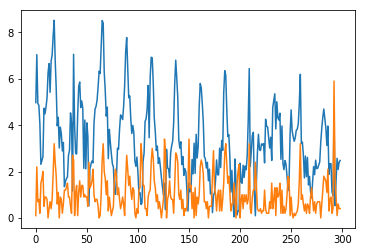

In [22]:

#plot(time, y.flatten())
plot(time, np.abs(y_cels.flatten() - data_cels[0,-m+1:].flatten()))
plot(time, np.abs(data_cels[0,-m+1:].flatten() - data_cels[0,-m:-1].flatten()))
show()

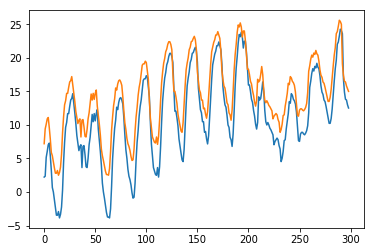

In [23]:
plot(time, y_cels.flatten())
plot(time, data_cels[0,-m+1:])
show()

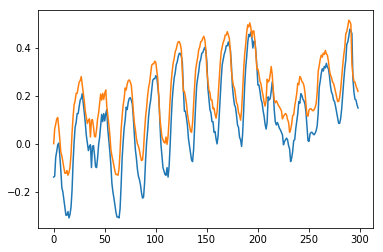

In [24]:
plot(time, y.flatten())
plot(time, test[:,:,1:].flatten())
show()